In [2]:
# Load libraries
# !pip install -r /work/NLP_IMDb_Exam/requirements.txt
import numpy as np
import pandas as pd
import torch
import datasets
import evaluate
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sentence_transformers import SentenceTransformer

2024-12-27 21:12:04.123095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735330324.143877    8982 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735330324.150260    8982 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 21:12:04.173712: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load dataframe into environment
IMDb_dataframe = pd.read_csv('/work/NLP_IMDb_Exam/Data/review_dataframe_subset.csv')

In [12]:
print(f"Total amount of 'Null'-ratings: {sum(IMDb_dataframe['rating']=="Null")}") # Count nulls
IMDb_dataframe = IMDb_dataframe[IMDb_dataframe['rating'] != "Null"] # Remove nulls
print(f"Total amount of 'Null'-ratings after cleaning: {sum(IMDb_dataframe['rating']=="Null")}") # Count nulls
IMDb_dataframe[IMDb_dataframe['movie_title'] == "2001_ A Space Odyssey"]

Total amount of 'Null'-ratings: 0
Total amount of 'Null'-ratings after cleaning: 0


,movie_title,year,rating,title,review,average_rating
127,2001_ A Space Odyssey,1968,10,"One of the greatest films of all time, the gre...",i first watched 2001 in 1970 and 13 i was then...,8.3
241,2001_ A Space Odyssey,1968,9,How unfortunate we never reached Clarke's visi...,on may 1st 1968 i attended the world premier a...,8.3
256,2001_ A Space Odyssey,1968,10,Greatest piece of Cinema..ever!\n,2001 was my favourite movie before i joined fi...,8.3
514,2001_ A Space Odyssey,1968,10,The movie about everything\n,2001 a space odyssey was released in 1968 and ...,8.3
768,2001_ A Space Odyssey,1968,10,2001  The year after next\n,kubrick has his finger thrust into every pie i...,8.3
...,...,...,...,...,...,...
98836,2001_ A Space Odyssey,1968,6,Not impressed.\n,being a huge fan of kubricks films i have to s...,8.3
99192,2001_ A Space Odyssey,1968,10,"""An epic drama of adventure and exploration""\n",ive finally watched the socalled masterpiece k...,8.3
99442,2001_ A Space Odyssey,1968,6,A slideshow accompanied by music and occasiona...,this movie sure might have been a lot more exi...,8.3
99731,2001_ A Space Odyssey,1968,9,The best movie ever made ?\n,one of the best movies of the history of cinem...,8.3


In [5]:
# Find a way to plot distributions of average_rating and infered rating. Also plot difference.
Movie_name = "Zulu"
IMDb_dataframe["rating"] = pd.to_numeric(IMDb_dataframe["rating"], errors="coerce")
Movie_rating = IMDb_dataframe[IMDb_dataframe['movie_title'] == Movie_name]["rating"]
Movie_rating_online = IMDb_dataframe[IMDb_dataframe['movie_title'] == Movie_name]["average_rating"]
mean_rating = Movie_rating.mean()
print(f"mean rating from reviews {mean_rating}, vs average imdb rating {float(Movie_rating_online.iloc[1])}")

mean rating from reviews 8.545454545454545, vs average imdb rating 7.7


In [10]:
def infer_rating(samples):
    # Filter NA's and ensure relevant columns are present
    imdb_filtered = IMDb_dataframe[['movie_title', 'rating', 'average_rating']].dropna()

    # Sample and compute inferred ratings using groupby
    sampled_ratings = (
        imdb_filtered
        .groupby('movie_title')
        .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())
    )

    # Convert to a DataFrame and reset index
    sampled_ratings_df = sampled_ratings.reset_index(name='infered')

    # Merge with original DataFrame to get IMDb average ratings
    merged = pd.merge(
        sampled_ratings_df,
        imdb_filtered[['movie_title', 'average_rating']].drop_duplicates(),
        on='movie_title'
    )

    # Compute the absolute difference
    merged['abs_diff'] = (merged['infered'] - merged['average_rating']).abs()

    #Compute mean squared error
    merged['squared_error'] =(merged['infered'] - merged['average_rating'])**2


    # Rename columns as required
    merged.rename(columns={'average_rating': 'IMDb'}, inplace=True)

    return merged[['infered', 'IMDb', 'abs_diff', 'squared_error']]

/tmp/ipykernel_8982/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())


The correlation between 'mean of 1 sample(s)' and 'Average online IMDb rating' is 0.3084687505095801
Mean Square Error for 1 samples: 6.9553933566433574


/tmp/ipykernel_8982/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())


The correlation between 'mean of 5 sample(s)' and 'Average online IMDb rating' is 0.5119635849972284
Mean Square Error for 5 samples: 1.791826923076923


/tmp/ipykernel_8982/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())


The correlation between 'mean of 20 sample(s)' and 'Average online IMDb rating' is 0.6666381724132048
Mean Square Error for 20 samples: 0.7177988707585577


/tmp/ipykernel_8982/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())


The correlation between 'mean of 50 sample(s)' and 'Average online IMDb rating' is 0.6985074437003488
Mean Square Error for 50 samples: 0.6099393707581253


/tmp/ipykernel_8982/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())


The correlation between 'mean of 200 sample(s)' and 'Average online IMDb rating' is 0.71257215902596
Mean Square Error for 200 samples: 0.5721085233189092


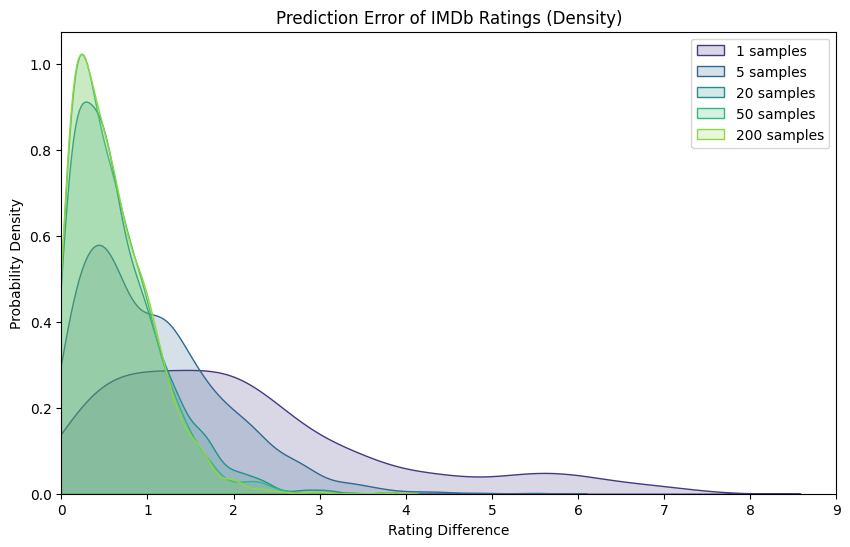

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

samples = [1, 5, 20, 50, 200]

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Loop through each sample size and plot the KDE curve for each sample size
for sample in samples:
    ratings_df = infer_rating(sample)
    
    # Plot KDE curve for each sample size (normalized to show probability density)
    sns.kdeplot(ratings_df['abs_diff'], color=sns.color_palette("viridis", len(samples))[samples.index(sample)],
                label=f'{sample} samples', alpha=0.2, fill=True)

    # Print correlation and MSE for the sample
    print(f"The correlation between 'mean of {sample} sample(s)' and 'Average online IMDb rating' is {ratings_df.corr().loc['infered', 'IMDb']}")
    print(f"Mean Square Error for {sample} samples: {ratings_df['squared_error'].mean()}")

# Add title and labels
plt.title('Prediction Error of IMDb Ratings (Density)')
plt.xlabel('Rating Difference')
plt.ylabel('Probability Density')

# Limit x-axis to [0, 9]
plt.xlim(0, 9)

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [16]:
# List of sample sizes
samples = [5, 10, 15, 20, 30, 40, 50]

# Create an empty list to store the results
results = []

# Loop through each sample size
for sample in samples:
    ratings_df = infer_rating(sample)
    
    # Extract the correlation and mean squared error
    correlation = ratings_df.corr().loc['infered', 'IMDb']
    mse = ratings_df['squared_error'].mean()
    
    # Append the results as a tuple (sample, correlation, mse)
    results.append((sample, correlation, mse))

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Sample Size', 'Correlation with IMDb', 'Mean Squared Error'])

# Display the DataFrame
results_df

/tmp/ipykernel_8982/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())
/tmp/ipykernel_8982/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())
/tmp/ipykernel_8982/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping col

,Sample Size,Correlation with IMDb,Mean Squared Error
0,5,0.502516,1.701302
1,10,0.614073,1.018947
2,15,0.628639,0.858619
3,20,0.676301,0.728660
4,30,0.689839,0.672515
5,40,0.704225,0.618088
6,50,0.699830,0.606452


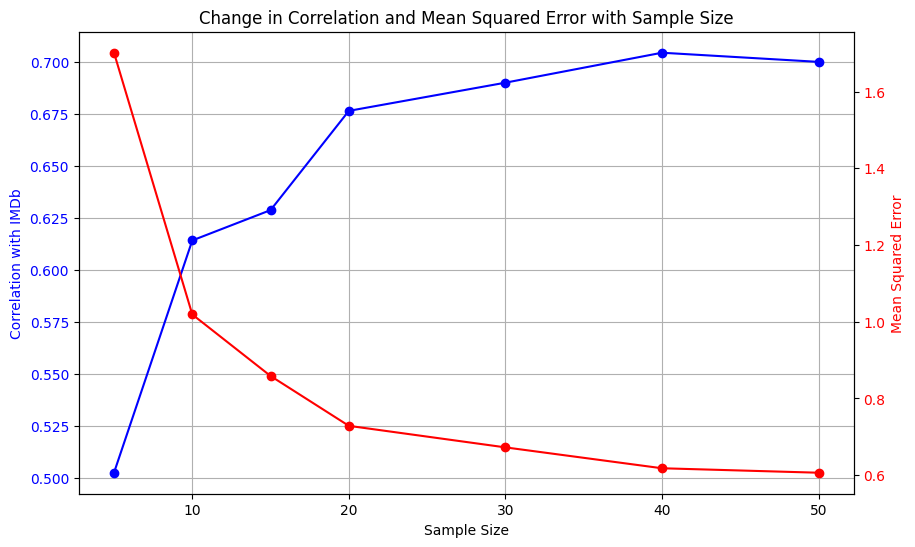

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming results_df is already defined as per your code

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the correlation with IMDb on the first y-axis
ax1.plot(results_df['Sample Size'], results_df['Correlation with IMDb'], label='Correlation with IMDb', color='b', marker='o')
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Correlation with IMDb', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create the second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the Mean Squared Error on the second y-axis
ax2.plot(results_df['Sample Size'], results_df['Mean Squared Error'], label='Mean Squared Error', color='r', marker='o')
ax2.set_ylabel('Mean Squared Error', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and grid
plt.title('Change in Correlation and Mean Squared Error with Sample Size')
ax1.grid(True)

# Display the plot
plt.show()


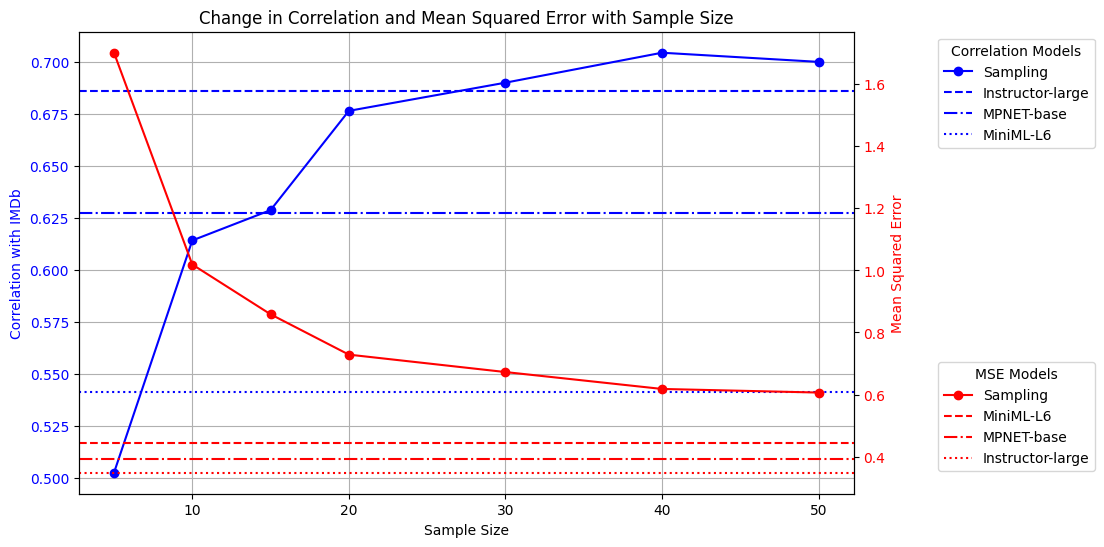

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming results_df is already defined as per your code
# Data for the models
model_data = [
    {'name': 'MiniML-L6', 'MSE': 0.4435, 'Correlation': 0.5411},
    {'name': 'MPNET-base', 'MSE': 0.3920, 'Correlation': 0.6271},
    {'name': 'Instructor-large', 'MSE': 0.3482, 'Correlation': 0.6859}
]

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the correlation with IMDb on the first y-axis
ax1.plot(results_df['Sample Size'], results_df['Correlation with IMDb'], label='Sampling', color='b', marker='o')
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Correlation with IMDb', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Define custom linestyle patterns for the models' correlation lines
linestyles = ['--', '-.', ':']
# Reversing the order of models for the correlation lines in the legend
for i, model in enumerate(reversed(model_data)):
    ax1.axhline(y=model['Correlation'], color='b', linestyle=linestyles[i], label=f'{model["name"]}')

# Create the second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the Mean Squared Error on the second y-axis
ax2.plot(results_df['Sample Size'], results_df['Mean Squared Error'], label='Sampling', color='r', marker='o')
ax2.set_ylabel('Mean Squared Error', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Define custom linestyle patterns for the models' MSE lines
mse_linestyles = ['--', '-.', ':']
for i, model in enumerate(model_data):
    ax2.axhline(y=model['MSE'], color='r', linestyle=mse_linestyles[i], label=f'{model["name"]}')

# Title and grid
plt.title('Change in Correlation and Mean Squared Error with Sample Size')
ax1.grid(True)

# Adding a legend
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1), title='Correlation Models')
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.3), title='MSE Models')

# Display the plot
plt.show()
